# **EuroSAT Land-Cover Classification with Vision Transformers and LoRA**

## 1. Install Dependencies

In [1]:
!pip install -q "torch" "torchvision" "transformers>=4.44.0" "datasets>=2.20.0" "peft>=0.12.0" "accelerate" "timm" "gradio" "evaluate"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00


## 2. Imports, Device Setup, Seeds

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from transformers import ViTForImageClassification
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType

import matplotlib.pyplot as plt
import numpy as np
import random, time, io
from tqdm.auto import tqdm
from PIL import Image


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


Using device: cuda


## 3. Load EuroSAT Dataset

In [4]:
dataset = load_dataset("blanchon/EuroSAT_RGB")
dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5400 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})

## 4. Assign Splits and Class Names

In [5]:
train_ds = dataset["train"]
val_ds   = dataset["validation"]
test_ds  = dataset["test"]

label_names = train_ds.features["label"].names
num_labels = len(label_names)

print("Classes:", label_names)
print(train_ds, val_ds, test_ds)


Classes: ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial Buildings', 'Pasture', 'Permanent Crop', 'Residential Buildings', 'River', 'SeaLake']
Dataset({
    features: ['image', 'label', 'filename'],
    num_rows: 16200
}) Dataset({
    features: ['image', 'label', 'filename'],
    num_rows: 5400
}) Dataset({
    features: ['image', 'label', 'filename'],
    num_rows: 5400
})


## 5. Visualize Sample Images

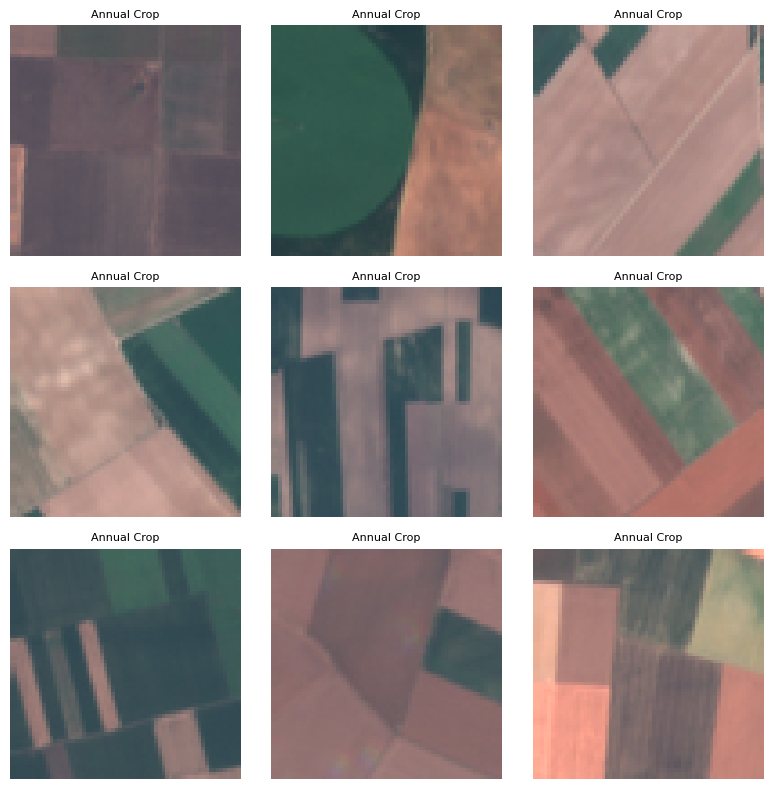

In [6]:
fig = plt.figure(figsize=(8,8))

for i in range(9):
    sample = train_ds[i]
    img = sample["image"]
    label = label_names[sample["label"]]

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(label, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


## 6. Define Transforms (Resize + Normalize)

In [7]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


## 7. PyTorch Dataset Wrapper (Fixes ALL HF Image Issues)

In [8]:
class EuroSATDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        example = self.ds[idx]
        img = example["image"]

        # CASE 1: raw HF bytes dict
        if isinstance(img, dict) and "bytes" in img:
            img = Image.open(io.BytesIO(img["bytes"])).convert("RGB")

        # CASE 2: numpy array
        elif isinstance(img, np.ndarray):
            img = Image.fromarray(img.astype("uint8")).convert("RGB")

        # CASE 3: list → convert to numpy
        elif isinstance(img, list):
            img = Image.fromarray(np.array(img).astype("uint8")).convert("RGB")

        # CASE 4: PIL Image
        else:
            img = img.convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = example["label"]
        return {"pixel_values": img, "label": label}


## 8. Create PyTorch Datasets & Dataloaders

In [9]:
train_pt = EuroSATDataset(train_ds, transform)
val_pt   = EuroSATDataset(val_ds, transform)
test_pt  = EuroSATDataset(test_ds, transform)

train_loader = DataLoader(train_pt, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_pt, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_pt, batch_size=64, shuffle=False)


## 9. Utility Functions — Train, Evaluate, Param Count

In [10]:
def count_trainable_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total, correct, loss_sum = 0, 0, 0

    for batch in tqdm(loader):
        x = batch["pixel_values"].to(device)
        y = torch.tensor(batch["label"]).to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=x)
        loss = criterion(outputs.logits, y)
        loss.backward()
        optimizer.step()

        preds = outputs.logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        loss_sum += loss.item()

    return loss_sum/len(loader), correct/total


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct = 0, 0

    for batch in loader:
        x = batch["pixel_values"].to(device)
        y = torch.tensor(batch["label"]).to(device)

        outputs = model(pixel_values=x)
        preds = outputs.logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total


## PART A — FULL FINE-TUNING VIT
# 10. Load Pretrained ViT

In [11]:
full_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True,
).to(device)

total_params_full, trainable_params_full = count_trainable_params(full_model)
print("Full FT total params:", total_params_full)
print("Full FT trainable params:", trainable_params_full)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Full FT total params: 85806346
Full FT trainable params: 85806346


# 11. Train Full Model

In [12]:
criterion_full = nn.CrossEntropyLoss()
optimizer_full = torch.optim.AdamW(full_model.parameters(), lr=5e-5)

num_epochs_full = 3
full_train_hist, full_val_hist, full_times = [], [], []


In [13]:
for epoch in range(1, num_epochs_full+1):
    start = time.time()

    train_loss, train_acc = train_one_epoch(full_model, train_loader, optimizer_full, criterion_full, device)
    val_acc = evaluate(full_model, val_loader, device)

    full_times.append(time.time() - start)
    full_train_hist.append((train_loss, train_acc))
    full_val_hist.append(val_acc)

    print(f"[FULL] Epoch {epoch}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, Time {full_times[-1]:.1f}s")


  0%|          | 0/254 [00:00<?, ?it/s]

/tmp/ipython-input-2266902484.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(batch["label"]).to(device)
/tmp/ipython-input-2266902484.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(batch["label"]).to(device)


[FULL] Epoch 1: Train Acc = 0.9412, Val Acc = 0.9757, Time 285.2s


  0%|          | 0/254 [00:00<?, ?it/s]

[FULL] Epoch 2: Train Acc = 0.9889, Val Acc = 0.9787, Time 287.5s


  0%|          | 0/254 [00:00<?, ?it/s]

[FULL] Epoch 3: Train Acc = 0.9951, Val Acc = 0.9809, Time 287.5s


# 12. Save Full Model

In [14]:
full_model.save_pretrained("vit_full_finetuned_eurosat")


## PART B — LoRA FINE-TUNING VIT
# 13. Load Fresh Model + Attach LoRA

In [15]:
lora_base = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True,
)

from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION,  # <-- FIXED HERE
    target_modules=["query", "key", "value"]
)

lora_model = get_peft_model(lora_base, lora_config).to(device)
lora_model.print_trainable_parameters()

total_params_lora, trainable_params_lora = count_trainable_params(lora_model)
print("LoRA total params:", total_params_lora)
print("LoRA trainable params:", trainable_params_lora)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 442,368 || all params: 86,248,714 || trainable%: 0.5129
LoRA total params: 86248714
LoRA trainable params: 442368


# 14. Train LoRA Model

In [16]:
criterion_lora = nn.CrossEntropyLoss()
optimizer_lora = torch.optim.AdamW(lora_model.parameters(), lr=5e-4)

num_epochs_lora = 3
lora_train_hist, lora_val_hist, lora_times = [], [], []


In [17]:
for epoch in range(1, num_epochs_lora+1):
    start = time.time()

    train_loss, train_acc = train_one_epoch(lora_model, train_loader, optimizer_lora, criterion_lora, device)
    val_acc = evaluate(lora_model, val_loader, device)

    lora_times.append(time.time() - start)
    lora_train_hist.append((train_loss, train_acc))
    lora_val_hist.append(val_acc)

    print(f"[LORA] Epoch {epoch}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, Time {lora_times[-1]:.1f}s")


  0%|          | 0/254 [00:00<?, ?it/s]

/tmp/ipython-input-2266902484.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(batch["label"]).to(device)
/tmp/ipython-input-2266902484.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(batch["label"]).to(device)


[LORA] Epoch 1: Train Acc = 0.8622, Val Acc = 0.9741, Time 249.8s


  0%|          | 0/254 [00:00<?, ?it/s]

[LORA] Epoch 2: Train Acc = 0.9796, Val Acc = 0.9772, Time 249.7s


  0%|          | 0/254 [00:00<?, ?it/s]

[LORA] Epoch 3: Train Acc = 0.9901, Val Acc = 0.9802, Time 249.9s


# 15. Save LoRA Model

In [18]:
lora_model.save_pretrained("vit_lora_finetuned_eurosat")


# PART C — Compare Models

In [19]:
print("=== PARAMETER COMPARISON ===")
print("Full FT trainable params:", trainable_params_full)
print("LoRA trainable params:", trainable_params_lora)

print("\n=== ACCURACY COMPARISON ===")
print("Final Full FT Val Acc:", full_val_hist[-1])
print("Final LoRA Val Acc:", lora_val_hist[-1])

print("\n=== SPEED COMPARISON ===")
print("Full FT avg epoch time:", np.mean(full_times))
print("LoRA avg epoch time:", np.mean(lora_times))


=== PARAMETER COMPARISON ===
Full FT trainable params: 85806346
LoRA trainable params: 442368

=== ACCURACY COMPARISON ===
Final Full FT Val Acc: 0.980925925925926
Final LoRA Val Acc: 0.9801851851851852

=== SPEED COMPARISON ===
Full FT avg epoch time: 286.7781439622243
LoRA avg epoch time: 249.79393450419107


# ** PART D — Gradio App with LoRA Model**

In [20]:
import gradio as gr

inference_model = lora_model
inference_model.eval()

def predict(img):
    img = img.convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        probs = F.softmax(inference_model(pixel_values=x).logits, dim=1)[0]

    top3 = torch.topk(probs, 3)
    return {label_names[i]: float(top3.values[j]) for j, i in enumerate(top3.indices)}

gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="EuroSAT Land Cover Classification (LoRA-ViT)"
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://138279e038625724fa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Trainig Loss and Accuracy

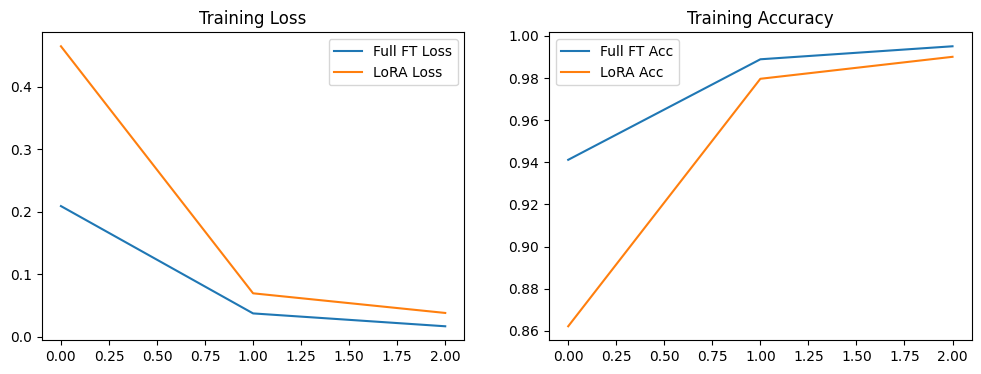

In [21]:
# FULL FINE-TUNING CURVES
full_loss = [x[0] for x in full_train_hist]
full_acc  = [x[1] for x in full_train_hist]
lor_acc   = [x[1] for x in lora_train_hist]
lor_loss  = [x[0] for x in lora_train_hist]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(full_loss, label="Full FT Loss")
plt.plot(lor_loss, label="LoRA Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(full_acc, label="Full FT Acc")
plt.plot(lor_acc, label="LoRA Acc")
plt.title("Training Accuracy")
plt.legend()

plt.show()


## Confusion Matrix

/tmp/ipython-input-1223933087.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(batch["label"])


<Figure size 1000x1000 with 0 Axes>

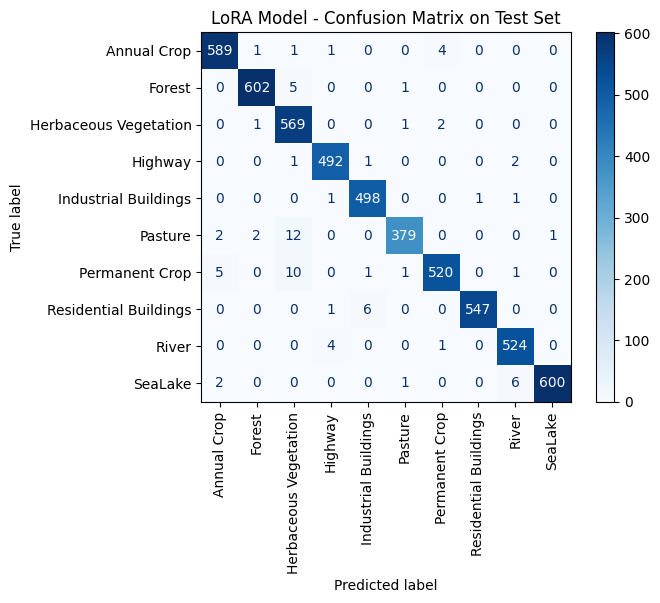

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_predictions(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch["pixel_values"].to(device)
            y = torch.tensor(batch["label"])
            logits = model(pixel_values=x).logits
            pred = logits.argmax(1).cpu().numpy()
            preds.extend(pred)
            labels.extend(y.numpy())
    return np.array(labels), np.array(preds)

y_true, y_pred = get_predictions(lora_model, test_loader)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
plt.figure(figsize=(10,10))
disp.plot(cmap="Blues", xticks_rotation=90)
plt.title("LoRA Model - Confusion Matrix on Test Set")
plt.show()


## Evaluation Metrics

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_names))


                       precision    recall  f1-score   support

          Annual Crop       0.98      0.99      0.99       596
               Forest       0.99      0.99      0.99       608
Herbaceous Vegetation       0.95      0.99      0.97       573
              Highway       0.99      0.99      0.99       496
 Industrial Buildings       0.98      0.99      0.99       501
              Pasture       0.99      0.96      0.97       396
       Permanent Crop       0.99      0.97      0.98       538
Residential Buildings       1.00      0.99      0.99       554
                River       0.98      0.99      0.99       529
              SeaLake       1.00      0.99      0.99       609

             accuracy                           0.99      5400
            macro avg       0.99      0.98      0.98      5400
         weighted avg       0.99      0.99      0.99      5400



## Lora Accuracy

In [24]:
test_acc = evaluate(lora_model, test_loader, device)
print("LoRA Test Accuracy:", test_acc)


/tmp/ipython-input-2266902484.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(batch["label"]).to(device)


LoRA Test Accuracy: 0.9851851851851852


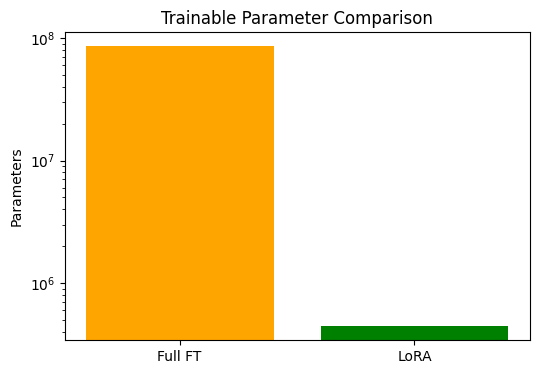

In [25]:
plt.figure(figsize=(6,4))
plt.bar(["Full FT","LoRA"], [trainable_params_full, trainable_params_lora], color=["orange","green"])
plt.title("Trainable Parameter Comparison")
plt.ylabel("Parameters")
plt.yscale("log")
plt.show()
